In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
lr = 1e-3
eps = 1e-8
batch_size = 128
epochs = 100

Dataset cifar-10

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 29940927.99it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = (train_dataloader, test_dataloader)

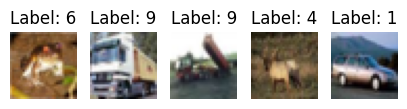

In [8]:
fig, ax = plt.subplots(1, 5,figsize=(5, 2))
for i in range(5):
    image, label = train_dataset[i] 
    image = image.permute(1, 2, 0)
    npimg = image.numpy()
    
    ax[i].imshow(npimg)
    ax[i].axis('off')
    ax[i].set_title(f'Label: {label}')
plt.show()

# The Model

In [10]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()
        self.latent_dim = 100
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.z_mean = nn.Linear(512*4*4, self.latent_dim)
        self.z_log = nn.Linear(512*4*4, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, input):
        bs = input.shape[0]

        x = self.relu(self.conv1(input))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        z_mean = self.z_mean(x)
        z_log = self.z_log(x)

        eps = torch.randn(bs, self.latent_dim, device=input.device)
        z_val = z_mean + torch.exp(z_log / 2) * eps
        return z_mean, z_log, z_val
    


class VAEDecoder(nn.Module):
    def __init__(self):
        super(VAEDecoder, self).__init__()
        self.latent_dim = 100
        self.fc1 = nn.Linear(self.latent_dim, 512*4*4)
        self.reshape = nn.Unflatten(1, (512, 4, 4))
        self.conv1 = nn.ConvTranspose2d(512, 256, 3, stride=2)
        self.conv2 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, 3, 2, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, input):
        x = self.relu(self.fc1(input))
        x = self.reshape(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        decoded = self.sigmoid(self.conv4(x))
        return decoded
    



class VAEAutoEncoder(nn.Module):
        
    def __init__(self):
        super(VAEAutoEncoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def forward(self, input):
        z_mean, z_log, z_val = self.encoder(input)
        decoded = self.decoder(z_val)
        return decoded, z_mean, z_log, z_val

In [11]:
model = VAEAutoEncoder()

if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

using 2 GPUs


DataParallel(
  (module): VAEAutoEncoder(
    (encoder): VAEEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (z_mean): Linear(in_features=8192, out_features=100, bias=True)
      (z_log): Linear(in_features=8192, out_features=100, bias=True)
      (relu): ReLU()
    )
    (decoder): VAEDecoder(
      (fc1): Linear(in_features=100, out_features=8192, bias=True)
      (reshape): Unflatten(dim=1, unflattened_size=(512, 4, 4))
      (conv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), s

**Loss Function** -> Reconstruction Loss + KL Divergence

In [12]:
def vae_loss(preds, targets, z_mean, z_log_var, z_val):
    reconstruction_loss = F.mse_loss(preds, targets, reduction='sum') / preds.size(0)
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    kl_divergence /= preds.size(0)  
    return reconstruction_loss + kl_divergence

In [13]:
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

**Training** for 100 epochs

In [14]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    epoch_train_losses = []

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch  
            imgs = imgs.to(device)

            optimizer.zero_grad()

            preds,z_mean, z_log, z_val = model(imgs)
            #print(preds.shape)
            #print(z_val.shape)
            loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, _ = batch
                imgs = imgs.to(device)

                preds,z_mean, z_log, z_val = model(imgs)
                
                loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        
        epoch_train_losses.append(train_loss)

        tqdm_dct = {'train loss': train_loss, 'test loss': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()
        
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, epochs + 1), epoch_train_losses, label='Train Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 100/100 [37:55<00:00, 22.75s/it, train loss=71.9, test loss=73.6]


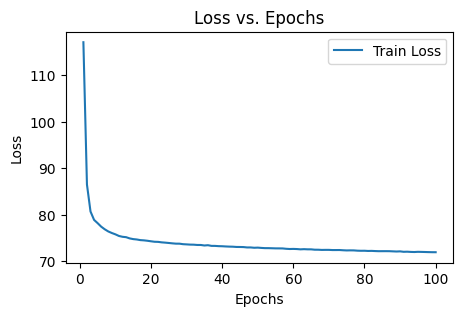

In [15]:
train_vae(dataloaders, model, optimizer, epochs, device)

Reconstructing the images 

In [17]:
def plot_images(n, images):
    fig, ax = plt.subplots(1, n, figsize=(12, 3)) 
    for i in range(n):

        if isinstance(images[i], tuple):
            image = images[i][0]
        else:
            image = images[i]

        image = image.permute(1, 2, 0).numpy()
        ax[i].imshow(image)
        ax[i].axis('off')
    plt.show()

torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([3, 32, 32])


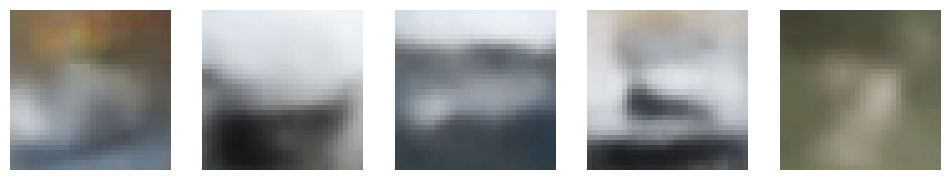

In [18]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
        
    output_imgs = model(data[0].to(device).unsqueeze(0))
    print(output_imgs[0].shape)
    print(output_imgs[3].shape)
    op_img = output_imgs[0].view(3, 32, 32)
    print(op_img.shape)
    predictions.append(op_img.detach().cpu())
plot_images(plots, predictions)

Sampling from the VAE Latent Space (Latent dim is 100)

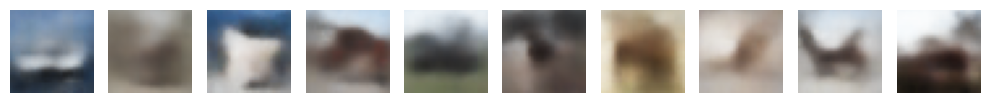

In [19]:
fig, axs = plt.subplots(1, 10, figsize=(10, 5))
for i in range(10):
    rand = torch.randn(1, 100).to(device)
    chek = model.module.decoder(rand)
    chek = chek.view(3, 32, 32)
    chek = chek.detach().cpu()
    
    col = i
    img = chek.permute(1, 2, 0).numpy()
    axs[col].imshow(img)
    axs[col].axis('off')
plt.tight_layout()
plt.show()